# LSTM for AQI forecasting

In [82]:
import numpy as np
import time
import json
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime as dt
from datetime import timedelta
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Reading data

In [83]:
#Local file
path = './datasets/'
object_name = 'madrid-air-quality.csv'
df = pd.read_csv(path + object_name)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.sort_values(by="date")
df.head(5)

,pm25,pm10,o3,no2,so2,co
date,,,,,,
2013-12-31,,13,20,18,2,
2014-01-01,34,11,21,22,2,
2014-01-02,36,14,23,25,1,
2014-01-03,40,10,30,15,1,
2014-01-04,26,15,26,17,1,


In [84]:
df.describe()

,pm25,pm10,o3,no2,so2,co
count,2897,2897,2897,2897,2897,2897
unique,123,74,84,68,15,1
top,56,17,30,21,2,
freq,75,120,120,131,728,2897


### Cleaning data

In [85]:
# Replacing blank spaces
df = df.replace(' ', '', regex=True)
df = df.replace('', np.nan, regex=True)

# Deleting co column
del df[' co']

df.isna().sum()

 pm25     19
 pm10     18
 o3       27
 no2      19
 so2     123
dtype: int64

In [86]:
# Dropping NaN
df = df.dropna(axis=0)
df

,pm25,pm10,o3,no2,so2
date,,,,,
2014-01-01,34,11,21,22,2
2014-01-02,36,14,23,25,1
2014-01-03,40,10,30,15,1
2014-01-04,26,15,26,17,1
2014-01-05,36,19,23,22,2
...,...,...,...,...,...
2022-03-25,39,17,28,12,1
2022-03-26,44,30,29,12,1
2022-03-27,92,50,33,17,1


In [87]:
# Converting to int
df= df.astype(int)
df.dtypes

 pm25    int64
 pm10    int64
 o3      int64
 no2     int64
 so2     int64
dtype: object

### Problem framing

To perform a AQI forecasting, we should perform the forecasting of each variable.

In [88]:
# Auxiliar functions series_to_supervised (Acknowledgement to Julia Ana for this code)
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        """
            Convert series to supervised learning (source): 
            https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)
        """
        n_vars = 1 if type(data) is list else data.shape[1]        
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [89]:
w_past = 30
w_forecasts = 30

reframed = series_to_supervised(df, w_past, w_forecasts) 
reframed

,var1(t-30),var2(t-30),var3(t-30),var4(t-30),var5(t-30),var1(t-29),var2(t-29),var3(t-29),var4(t-29),var5(t-29),...,var1(t+28),var2(t+28),var3(t+28),var4(t+28),var5(t+28),var1(t+29),var2(t+29),var3(t+29),var4(t+29),var5(t+29)
date,,,,,,,,,,,,,,,,,,,,,
2014-02-04,34.0,11.0,21.0,22.0,2.0,36.0,14.0,23.0,25.0,1.0,...,51.0,26.0,27.0,31.0,4.0,57.0,27.0,36.0,32.0,5.0
2014-02-05,36.0,14.0,23.0,25.0,1.0,40.0,10.0,30.0,15.0,1.0,...,57.0,27.0,36.0,32.0,5.0,55.0,22.0,40.0,19.0,3.0
2014-02-06,40.0,10.0,30.0,15.0,1.0,26.0,15.0,26.0,17.0,1.0,...,55.0,22.0,40.0,19.0,3.0,47.0,27.0,31.0,34.0,5.0
2014-02-09,26.0,15.0,26.0,17.0,1.0,36.0,19.0,23.0,22.0,2.0,...,47.0,27.0,31.0,34.0,5.0,57.0,28.0,37.0,30.0,4.0
2014-02-10,36.0,19.0,23.0,22.0,2.0,43.0,22.0,16.0,28.0,3.0,...,57.0,28.0,37.0,30.0,4.0,59.0,32.0,35.0,25.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-22,53.0,15.0,25.0,26.0,2.0,46.0,34.0,27.0,25.0,2.0,...,34.0,21.0,22.0,16.0,1.0,39.0,17.0,28.0,12.0,1.0
2022-02-23,46.0,34.0,27.0,25.0,2.0,44.0,17.0,28.0,27.0,2.0,...,39.0,17.0,28.0,12.0,1.0,44.0,30.0,29.0,12.0,1.0
2022-02-24,44.0,17.0,28.0,27.0,2.0,42.0,22.0,29.0,33.0,2.0,...,44.0,30.0,29.0,12.0,1.0,92.0,50.0,33.0,17.0,1.0


In [90]:
# Some variables
forecast_feature = ' pm25'

n_features = 5
n_past, n_forecasts = w_past, w_forecasts
n_features_out = 1
n_obs = n_features * n_past

w_train = (0, 2549)
w_validation = (2550, 2742)
w_test = (2550, 2742)

# defining X and Y
n_obs_in = (n_features * n_past)
n_obs_out = (n_features_out * n_forecasts)

X = reframed.values[:, :n_obs_in]
y = reframed.filter(regex='var1', axis=1)
y = y.iloc[:,-n_forecasts:].values

print(X.shape, y.shape)

(2696, 150) (2696, 30)


In [91]:
# MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(0,1)).fit(X)
y_scaler = MinMaxScaler(feature_range=(0,1)).fit(y)

In [92]:
# Split X, y
X_train = X[w_train[0]:w_train[1] +1, :n_obs]
y_train = y[w_train[0]:w_train[1] +1 , :] 
X_val = X[w_validation[0]:w_validation[1] +1, :n_obs]
y_val = y[w_validation[0]:w_validation[1] +1, :]
X_test = X[w_test[0]:w_test[1] +1, :n_obs]
y_test= y[w_test[0]:w_test[1] +1, :] 

print('Shape of splits:')
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape,'\n')

Shape of splits:
(2550, 150) (2550, 30) (146, 150) (146, 30) (146, 150) (146, 30) 



In [93]:
 pd.DataFrame(X[w_validation[0]:w_validation[1] +1, :n_obs])

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,83.0,48.0,61.0,28.0,3.0,97.0,49.0,56.0,27.0,5.0,...,88.0,35.0,46.0,21.0,4.0,72.0,41.0,50.0,19.0,4.0
1,97.0,49.0,56.0,27.0,5.0,98.0,50.0,43.0,30.0,3.0,...,72.0,41.0,50.0,19.0,4.0,89.0,40.0,47.0,16.0,3.0
2,98.0,50.0,43.0,30.0,3.0,102.0,39.0,43.0,10.0,2.0,...,89.0,40.0,47.0,16.0,3.0,79.0,33.0,42.0,12.0,4.0
3,102.0,39.0,43.0,10.0,2.0,67.0,34.0,44.0,11.0,2.0,...,79.0,33.0,42.0,12.0,4.0,74.0,47.0,47.0,13.0,3.0
4,67.0,34.0,44.0,11.0,2.0,59.0,53.0,47.0,13.0,2.0,...,74.0,47.0,47.0,13.0,3.0,107.0,50.0,55.0,22.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,53.0,15.0,25.0,26.0,2.0,46.0,34.0,27.0,25.0,2.0,...,42.0,18.0,30.0,28.0,1.0,48.0,15.0,28.0,26.0,1.0
142,46.0,34.0,27.0,25.0,2.0,44.0,17.0,28.0,27.0,2.0,...,48.0,15.0,28.0,26.0,1.0,41.0,18.0,25.0,31.0,1.0
143,44.0,17.0,28.0,27.0,2.0,42.0,22.0,29.0,33.0,2.0,...,41.0,18.0,25.0,31.0,1.0,44.0,28.0,21.0,33.0,2.0
144,42.0,22.0,29.0,33.0,2.0,52.0,26.0,28.0,34.0,2.0,...,44.0,28.0,21.0,33.0,2.0,56.0,16.0,24.0,20.0,1.0


In [94]:
# Using the X,y scalers, scale the data
X_train, y_train = X_scaler.transform(X_train), y_scaler.transform(y_train)
X_val, y_val = X_scaler.transform(X_val), y_scaler.transform(y_val)
X_test, y_test = X_scaler.transform(X_test), y_scaler.transform(y_test)

In [95]:
# Reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_past, n_features))
X_val = X_val.reshape((X_val.shape[0], n_past, n_features))
X_test = X_test.reshape((X_test.shape[0], n_past, n_features))
print('Re-shaped for LSTM:')
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

Re-shaped for LSTM:
(2550, 30, 5) (2550, 30) (146, 30, 5) (146, 30) (146, 30, 5) (146, 30)


### Model 

In [96]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU

In [97]:
# Design network
#input shape = (loockback, num_features)
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(GRU(50,activation='relu',return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu',return_sequences=True))
#model.add(GRU(50, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
#model.add(GRU(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(n_forecasts))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 30, 50)            11200     
                                                                 
 dropout_15 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_18 (LSTM)              (None, 30, 50)            20200     
                                                                 
 dropout_16 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_19 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_17 (Dropout)        (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 30)               

In [71]:
# Training
start_time = time.time()
history = model.fit(X_train, y_train, 
                    epochs=25, batch_size=10, 
                    validation_data=(X_val, y_val), 
                    verbose=2, shuffle=False)
training_time = time.time() - start_time

Epoch 1/25
255/255 - 8s - loss: 0.1297 - val_loss: 0.1099 - 8s/epoch - 30ms/step
Epoch 2/25
255/255 - 6s - loss: 0.1070 - val_loss: 0.1071 - 6s/epoch - 23ms/step
Epoch 3/25
255/255 - 6s - loss: 0.1041 - val_loss: 0.1055 - 6s/epoch - 24ms/step
Epoch 4/25
255/255 - 6s - loss: 0.1022 - val_loss: 0.1060 - 6s/epoch - 23ms/step
Epoch 5/25
255/255 - 6s - loss: 0.1014 - val_loss: 0.1052 - 6s/epoch - 23ms/step
Epoch 6/25
255/255 - 6s - loss: 0.1005 - val_loss: 0.1047 - 6s/epoch - 23ms/step
Epoch 7/25
255/255 - 6s - loss: 0.1002 - val_loss: 0.1056 - 6s/epoch - 23ms/step
Epoch 8/25
255/255 - 6s - loss: 0.0998 - val_loss: 0.1039 - 6s/epoch - 23ms/step
Epoch 9/25
255/255 - 6s - loss: 0.0992 - val_loss: 0.1042 - 6s/epoch - 22ms/step
Epoch 10/25
255/255 - 6s - loss: 0.0990 - val_loss: 0.1092 - 6s/epoch - 23ms/step
Epoch 11/25
255/255 - 6s - loss: 0.0989 - val_loss: 0.1053 - 6s/epoch - 22ms/step
Epoch 12/25
255/255 - 5s - loss: 0.0984 - val_loss: 0.1050 - 5s/epoch - 21ms/step
Epoch 13/25
255/255 - 6s 

In [72]:
# Saving model
date = dt.now().date()
model.save(f'models/LSTM{date}.h5')

/tmp/ipykernel_1990/4042831328.py:13: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', color='b', linestyle='-')


(0.0, 25.0)

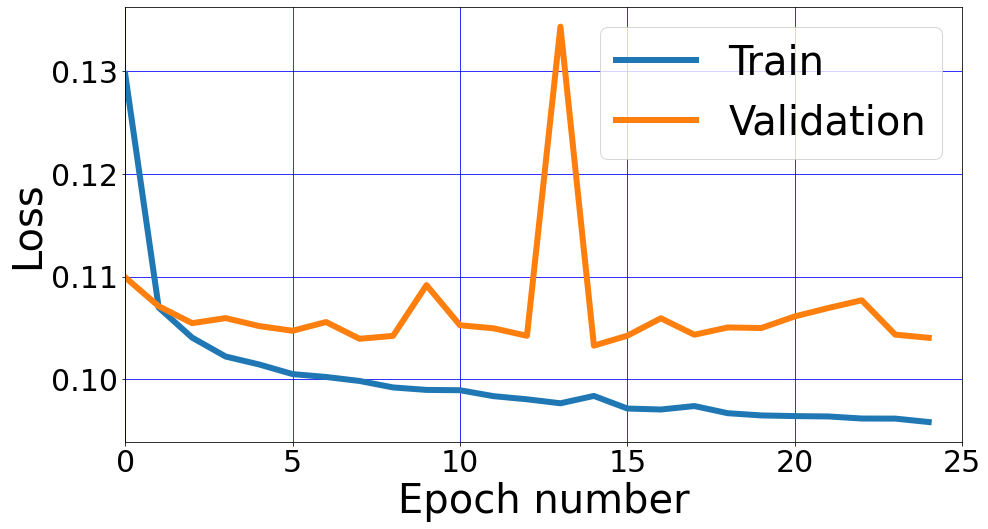

In [73]:
# Evaluation

figure=plt.figure(figsize=(15, 8))

# plot history
plt.plot(history.history['loss'], label='Train', linewidth=6)
plt.plot(history.history['val_loss'], label='Validation', linewidth=6)
plt.legend()

ax = plt.gca()
ax.set_facecolor((1.0, 1.0, 1.0))
ax.margins(x=0)
ax.grid(b=True, which='major', color='b', linestyle='-')
# ax.yaxis.set_major_locator(mtick.LinearLocator(5))
ax.tick_params(axis='both', which='major', direction='out', labelsize=30)
ax.set_xlabel('Epoch number', fontsize=40)
ax.set_ylabel('Loss', fontsize=40)
ax.legend( fontsize=40, loc='best')
ax.grid(True)


plt.xlim([0,25])
#ax.set_ylim([0,0.1])
# figure.savefig(f'figures/training-loss.png', bbox_inches='tight')
# figure.savefig(f'figures/training-loss.svg', bbox_inches='tight')

### Predicton

In [74]:
# Reshape X_test[0] into 3D
x_input = X_test[0].reshape((1, n_past, n_features))
print ('x_input shape: ',x_input.shape)

# Make the prediction
yhat = model.predict(x_input)

x_input shape:  (1, 30, 5)


In [75]:
 print ('yhat shape:', yhat[0].shape)

# Invert the scaling for yhat using the y_scaler from above
inv_yhat = y_scaler.inverse_transform(yhat)
inv_yhat

yhat shape: (30,)


array([[50.238045, 50.729332, 51.173   , 51.169605, 51.569763, 51.776035,
        52.10116 , 52.3     , 52.23484 , 52.443775, 52.357853, 52.63501 ,
        52.450726, 52.584267, 52.415504, 52.513767, 52.27424 , 52.06986 ,
        51.623913, 51.64633 , 51.737213, 51.684513, 51.92186 , 51.750084,
        52.20908 , 52.115746, 52.584507, 52.62649 , 52.546955, 52.63065 ]],
      dtype=float32)

In [76]:
# Checking the shape of y_test[0]
print ('y_test shape:' , y_test[0].shape)

# Reshape y_test
inv_y = y_scaler.inverse_transform(y_test)

inv_y = inv_y[0].reshape(1, inv_y[0].shape[0])
print('inv_y shape:', inv_y.shape)

y_test shape: (30,)
inv_y shape: (1, 30)


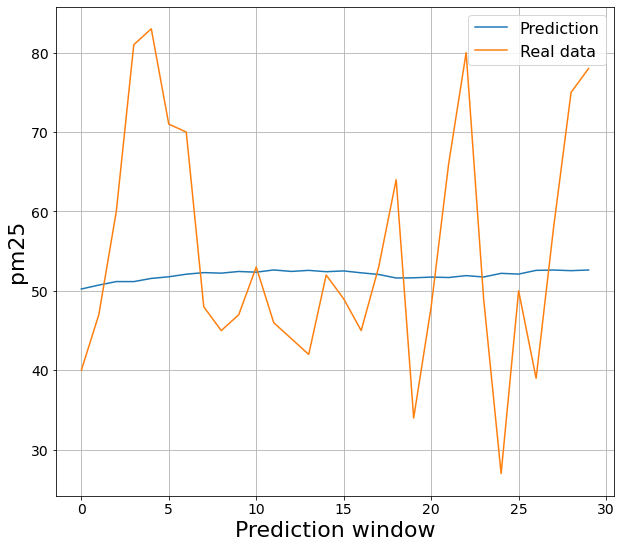

In [77]:
plt.figure(figsize=(10,9))
plt.plot(inv_yhat[0], label='Prediction')
plt.plot(inv_y[0], label='Real data')
plt.xlabel('Prediction window', fontsize=22)
plt.ylabel('pm25', fontsize=22)
# plt.rc('axes', labelsize=1)    # fontsize of the x and y labels
plt.rcParams.update({'font.size': 14})
plt.legend(fontsize=16)
plt.grid()
plt.show()

In [78]:
mse = mean_squared_error(y_test[0], yhat[0])
print ('Mean Squared Error:',mse)

mae = mean_absolute_error(y_test[0], yhat[0])
print ('Mean Absolute Error:',mae)

Mean Squared Error: 0.009503170586516646
Mean Absolute Error: 0.0763936174640364


In [79]:
X_test_plot = df.iloc[w_validation[0]:w_validation[1] +1][:n_obs][forecast_feature] # we take initial df + filter index of validation 

In [80]:
# Create dataframe with prediction
forecast = pd.DataFrame()
forecast[forecast_feature] = inv_yhat[0] 
forecast[forecast_feature][forecast[forecast_feature]<0]=0   # min value is 0 
# we add 72h to the last index of X_test_plot(used for the prediction)
forecast.index = pd.date_range(start=X_test_plot.index.max(),periods=w_forecasts,freq='D')  

                 pm25
2021-12-11  50.238045
2021-12-12  50.729332
2021-12-13  51.173000
2021-12-14  51.169605
2021-12-15  51.569763
2021-12-16  51.776035
2021-12-17  52.101158
2021-12-18  52.299999
2021-12-19  52.234840
2021-12-20  52.443775
2021-12-21  52.357853
2021-12-22  52.635010
2021-12-23  52.450726
2021-12-24  52.584267
2021-12-25  52.415504
2021-12-26  52.513767
2021-12-27  52.274239
2021-12-28  52.069859
2021-12-29  51.623913
2021-12-30  51.646332
2021-12-31  51.737213
2022-01-01  51.684513
2022-01-02  51.921860
2022-01-03  51.750084
2022-01-04  52.209080
2022-01-05  52.115746
2022-01-06  52.584507
2022-01-07  52.626492
2022-01-08  52.546955
2022-01-09  52.630650


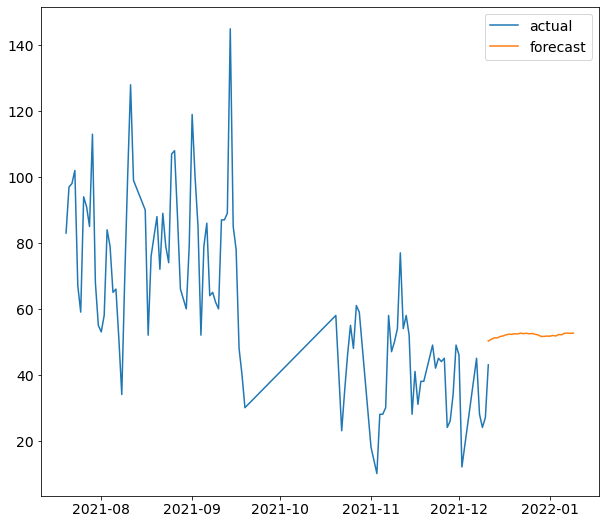

In [81]:
print(forecast)

plt.figure(figsize=(10,9))
plt.plot(X_test_plot,label='actual')
plt.plot(forecast, label='forecast')
plt.legend()
plt.show()